## Main figures for P2L

We want to discuss the following simulations:
- High resolution
- 20 km no param
- 20 km ANN
- 20 km GM

The main thing we want to discuss are:
- Overturning transport
- APE reduction rates
- APE reduction cross-spectra
- Equlibrated KE and PE 

In [1]:
import xarray as xr
import xrft
import matplotlib.pyplot as plt
import numpy as np
from xgcm import Grid
from datatree import open_datatree, DataTree 

import sys
sys.path.append('../modules/')

%reload_ext autoreload
%autoreload 2

In [2]:
import sim_analysis_modules as sam

In [3]:
# Load HR model
dir_HR = '/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/Phillips_2layer_4km/'
ds_HR = xr.open_dataset(dir_HR+'prog.nc', decode_times=False)

ERROR 1: PROJ: proj_create_from_database: Open of /ext3/miniforge/share/proj failed


In [4]:
not_before = False
if not_before:
    ds_filt = sam.filter_dataset(ds_HR, int(100e3/4e3))
    ds_filt_coarse = sam.coarsen_dataset(ds_filt, 5)
    ds_filt['RV'] = ds_filt.dvdx - ds_filt.dudy
    ds_filt_coarse['RV'] = ds_filt_coarse.dvdx - ds_filt_coarse.dudy
    ds_filt_coarse['RV'].attrs = ds_HR['RV'].attrs
    
    ds_filt_coarse.to_netcdf('/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/Phillips_2layer_4km/prog_filt_100km.nc')
else: 
    ds_filt_coarse = xr.open_dataset('/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/Phillips_2layer_4km/prog_filt_100km.nc')

In [5]:
ds_filt_coarse = sam.add_filt_coarse_transport(ds_filt_coarse)

20000.0


In [6]:
ds_HR = sam.add_HR_transport(ds_HR)

In [7]:
ds_HR = sam.add_energy_metrics(ds_HR)

In [8]:
exp_dir = '/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/27Mar/'

model_types = ['ANN', 'GM1000']
res = np.array([20])
C_ANN = np.array([0.0, 1.0])
C_GM = np.array([1000, 8000])/1000

# Load 20 km no param
# Load 20 km ANN
# Load 20 km GM
exp_tree = sam.load_sims(exp_dir, 
                         model_types,
                         res,
                         C_ANN,
                         C_GM)

Reading :res_20km_ANN_0.0
Reading :res_20km_ANN_1.0
Reading :res_20km_GM1000_1.0
Reading :res_20km_GM1000_8.0


In [9]:
oce_geom = xr.open_dataset('/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/27Mar/runs/res_10km_ANN_0.0/OUTPUT/ocean_geometry.nc')
ver_coord = xr.open_dataset('/scratch/db194/mom6/base_experiments_2025/Phillip2Layer/27Mar/runs/res_10km_ANN_0.0/OUTPUT/Vertical_coordinate.nc')

### Plots

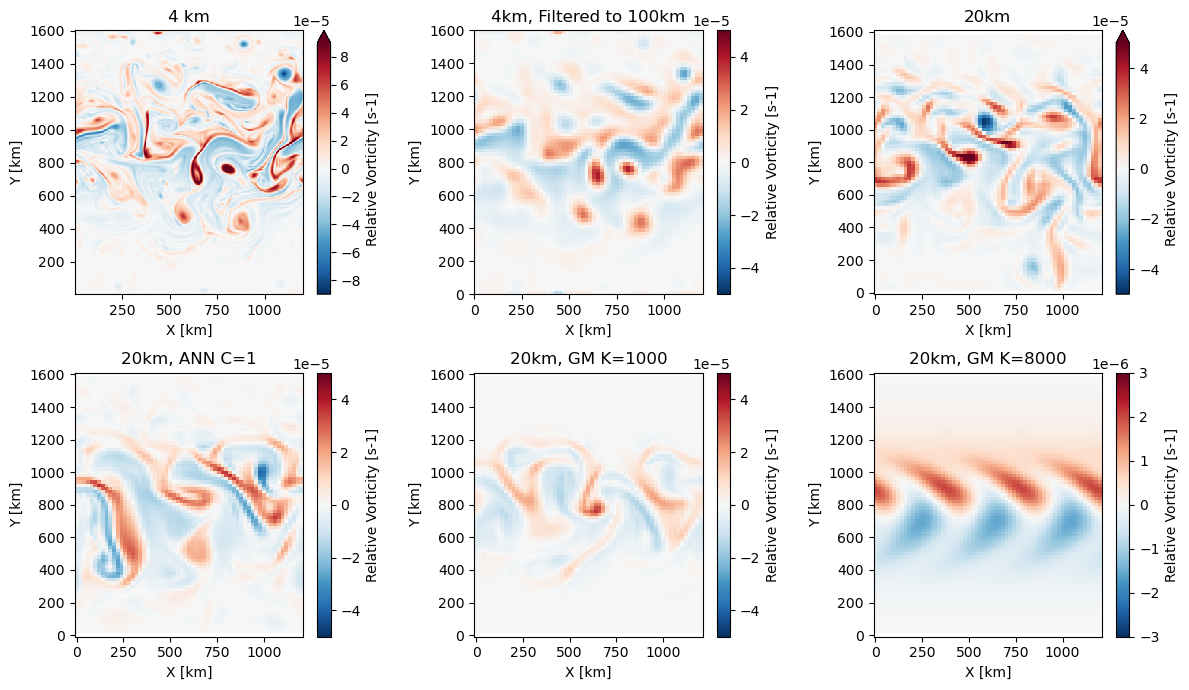

In [10]:
plt.figure(figsize=(12, 7))

plt.subplot(231)
ds_HR.RV.isel(Time=-1, zl=0).plot(vmin=-9e-5)
plt.title('4 km')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.subplot(232)
ds_filt_coarse.RV.isel(Time=-1, zl=0).plot(vmin=-5e-5)
plt.title('4km, Filtered to 100km')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.subplot(233)
exp_tree['ANN']['20']['0.0']['prog'].RV.isel(Time=-1, zl=0).plot(vmin=-5e-5)
plt.title('20km')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.subplot(234)
exp_tree['ANN']['20']['1.0']['prog'].RV.isel(Time=-1, zl=0).plot(vmin=-5e-5)
plt.title('20km, ANN C=1')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.subplot(235)
exp_tree['GM1000']['20']['1.0']['prog'].RV.isel(Time=-1, zl=0).plot(vmin=-5e-5)
plt.title('20km, GM K=1000')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.subplot(236)
exp_tree['GM1000']['20']['8.0']['prog'].RV.isel(Time=-1, zl=0).plot(vmin=-3e-6)
plt.title('20km, GM K=8000')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')

plt.tight_layout()

plt.savefig('RV_main_models.png')

### KE Spectra

In [11]:
v_HR_ps = xrft.power_spectrum(ds_HR.v, dim='xh').isel(Time=slice(-144, None)).mean(['Time', 'yq'])

In [12]:
v_HR_filt_coarse_ps = xrft.power_spectrum(ds_filt_coarse.vbar, dim='xh').isel(Time=slice(-144, None)).mean(['Time', 'yh'])

In [13]:
v_noparam = xrft.power_spectrum(exp_tree['ANN']['20']['0.0']['prog'].v, dim='xh').isel(Time=slice(-144, None)).mean(['Time', 'yq'])

In [14]:
v_ANN = xrft.power_spectrum(exp_tree['ANN']['20']['1.0']['prog'].v, dim='xh').isel(Time=slice(-144, None)).mean(['Time', 'yq'])
v_GM1000 = xrft.power_spectrum(exp_tree['GM1000']['20']['1.0']['prog'].v, dim='xh').isel(Time=slice(-144, None)).mean(['Time', 'yq'])
v_GM8000 = xrft.power_spectrum(exp_tree['GM1000']['20']['8.0']['prog'].v, dim='xh').isel(Time=slice(-144, None)).mean(['Time', 'yq'])

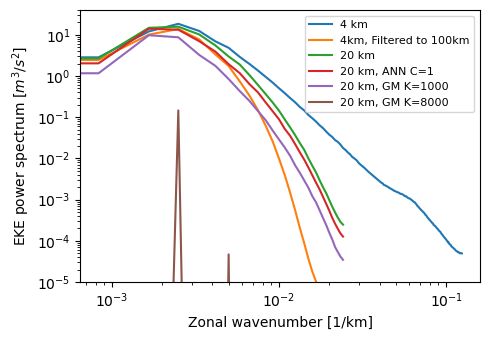

In [15]:
plt.figure(figsize=(5,3.5))

v_HR_ps.isel(zl=0).plot(label='4 km')
v_HR_filt_coarse_ps.isel(zl=0).plot(label='4km, Filtered to 100km')
v_noparam.isel(zl=0).plot(label='20 km')
v_ANN.isel(zl=0).plot(label='20 km, ANN C=1')
v_GM1000.isel(zl=0).plot(label='20 km, GM K=1000')
v_GM8000.isel(zl=0).plot(label='20 km, GM K=8000')

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5, 40])
plt.legend(loc='upper right', fontsize=8)
plt.title('')
plt.xlabel('Zonal wavenumber [1/km]')
plt.ylabel('EKE power spectrum [$m^3/s^2$]')
plt.tight_layout()
plt.savefig('P2L_spec.png')

### Overturning transport

In [16]:
exp_tree = exp_tree.map_over_subtree(sam.add_transport_metrics)

In [17]:
exp_ds_ave = [ds_HR, 
              ds_filt_coarse,
          exp_tree['ANN']['20']['0.0']['ave_prog'],
          exp_tree['ANN']['20']['1.0']['ave_prog'],
          exp_tree['GM1000']['20']['1.0']['ave_prog'],
          exp_tree['GM1000']['20']['8.0']['ave_prog']]


exp_names = ['4 km', '4 km filtered to 100km', '20 km', '20 km, ANN=1', '20km, GM=1000', '20km, GM=8000']
Vbar_resolved = np.zeros(len(exp_names))
Vbar_param = np.zeros(len(exp_names))
Vbar_sg = np.zeros(len(exp_names))

zl = 0

for i, ds in enumerate(exp_ds_ave):
    Vbar_resolved[i] = np.max(ds['Vbar_resolved'].isel(zl=zl))
    if i == 1: 
        Vbar_sg[i] = np.max(ds['Vbar_SG'].isel(zl=zl))
    if i>1:
        Vbar_param[i] = np.max(ds['Vbar_param'].isel(zl=zl))

# Hacky fix since we don't keep track of coarse grained data
#Vbar_resolved[0] = Vbar_resolved[1] + Vbar_sg[1]
Vbar_resolved[1] = Vbar_resolved[0] - Vbar_sg[1] 

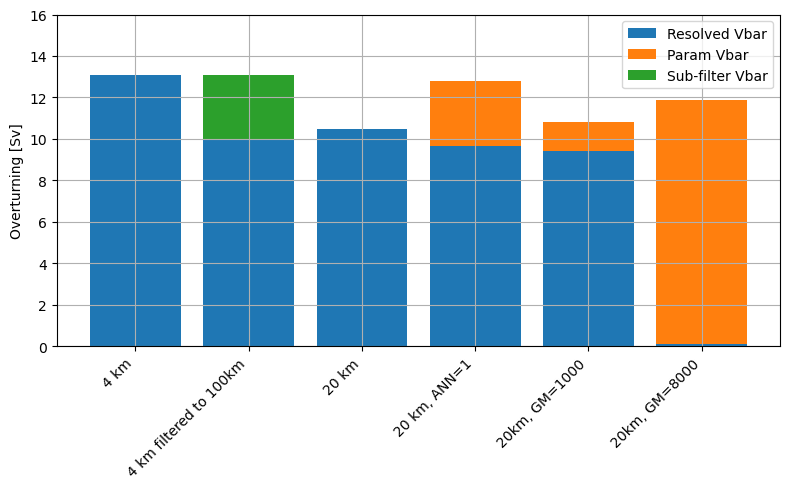

In [18]:
# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(exp_names))

# Plot the resolved part (bottom)
ax.bar(x, Vbar_resolved, label='Resolved Vbar')

# Plot the param part (stacked on top)
ax.bar(x, Vbar_param, bottom=Vbar_resolved, label='Param Vbar')

# Plot the sub-grid part (stacked on top)
ax.bar(x, Vbar_sg, bottom=Vbar_resolved+Vbar_param, label='Sub-filter Vbar')


# Labeling
ax.set_xticks(x)
ax.set_xticklabels(exp_names, rotation=45, ha='right')
ax.set_ylabel('Overturning [Sv]')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax.legend()

ax.set_ylim(0, 16)
plt.grid()
plt.tight_layout()

plt.savefig('P2L_overturning.png')

In [19]:
exp_tree = exp_tree.map_over_subtree(sam.add_zonal_eddy_mean_transport_metrics)

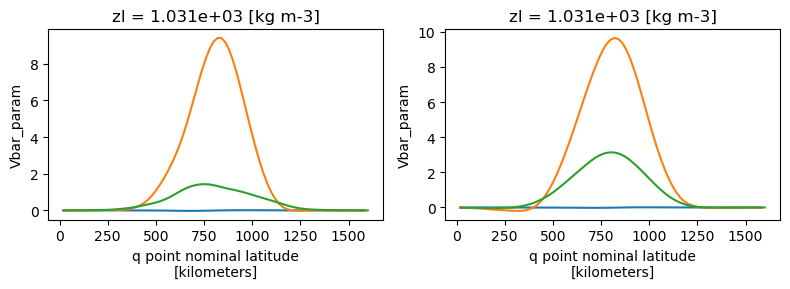

In [20]:
plt.figure(figsize=(8,3))

plt.subplot(121)
exp_tree['GM1000']['20']['1.0']['ave_prog']['Vbar_mean'].isel(zl=zl).plot()
exp_tree['GM1000']['20']['1.0']['ave_prog']['Vbar_eddy'].isel(zl=zl).plot()
exp_tree['GM1000']['20']['1.0']['ave_prog']['Vbar_param'].isel(zl=zl).plot()

plt.subplot(122)
exp_tree['ANN']['20']['1.0']['ave_prog']['Vbar_mean'].isel(zl=zl).plot()
exp_tree['ANN']['20']['1.0']['ave_prog']['Vbar_eddy'].isel(zl=zl).plot()
exp_tree['ANN']['20']['1.0']['ave_prog']['Vbar_param'].isel(zl=zl).plot()

plt.tight_layout()

### KE and APE

In [21]:
ds_filt_coarse = sam.add_energy_metrics_filt_coarse(ds_filt_coarse)

In [22]:
exp_tree = exp_tree.map_over_subtree(sam.add_energy_metrics)

In [23]:
exp_ds = [ds_HR, 
          ds_filt_coarse, 
          exp_tree['ANN']['20']['0.0']['prog'],
          exp_tree['ANN']['20']['1.0']['prog'],
          exp_tree['GM1000']['20']['1.0']['prog'],
          exp_tree['GM1000']['20']['8.0']['prog']]
          

MKE = np.zeros(len(exp_ds))
EKE = np.zeros(len(exp_ds))
EKE_SubFilter = np.zeros(len(exp_ds))

MAPE = np.zeros(len(exp_ds))
EAPE = np.zeros(len(exp_ds))
EAPE_SubFilter = np.zeros(len(exp_ds))

for i, ds in enumerate(exp_ds):
    MKE[i] = ds['MKE'].values
    EKE[i] = ds['EKE'].isel(Time=slice(72, None)).mean('Time').values

    
    MAPE[i] = ds['MAPE'].values
    EAPE[i] = ds['EAPE'].isel(Time=slice(72, None)).mean('Time').values
    

EKE_SubFilter[1] = EKE[0] - EKE[1]
EAPE_SubFilter[1] = EAPE[0] - EAPE[1]


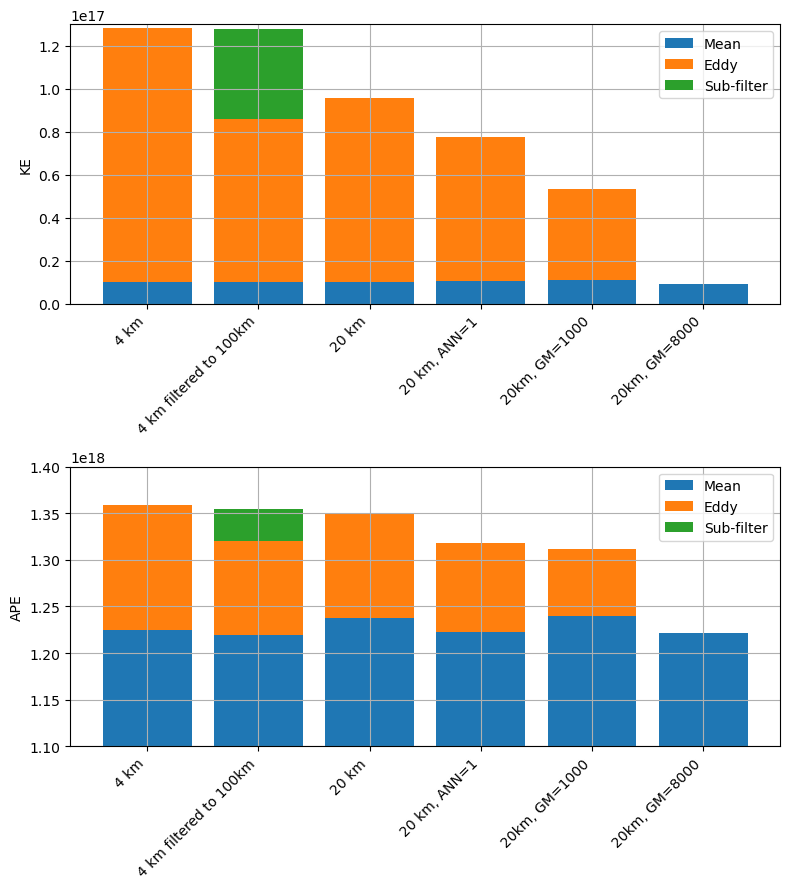

In [31]:
# Create the stacked bar plot
fig, ax = plt.subplots(2,1, figsize=(8, 9))

x = np.arange(len(exp_names))

# Plot the resolved part (bottom)
ax[0].bar(x, MKE, label='Mean')

# Plot the param part (stacked on top)
ax[0].bar(x, EKE, bottom=MKE, label='Eddy')

# Plot the param part (stacked on top)
ax[0].bar(x, EKE_SubFilter, bottom=MKE+EKE, label='Sub-filter')


# Labeling
ax[0].set_xticks(x)
ax[0].set_xticklabels(exp_names, rotation=45, ha='right')
ax[0].set_ylabel('KE')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax[0].legend()

ax[0].set_ylim(0, 1.3e17)
ax[0].grid()


# Plot the resolved part (bottom)
ax[1].bar(x, MAPE, label='Mean')

# Plot the param part (stacked on top)
ax[1].bar(x, EAPE, bottom=MAPE, label='Eddy')


# Plot the param part (stacked on top)
ax[1].bar(x, EAPE_SubFilter, bottom=MAPE+EAPE, label='Sub-filter')

# Labeling
ax[1].set_xticks(x)
ax[1].set_xticklabels(exp_names, rotation=45, ha='right')
ax[1].set_ylabel('APE')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax[1].legend()

ax[1].set_ylim(1.1e18, 1.4e18)
ax[1].grid()

plt.tight_layout()

plt.savefig('energy_levels_P2L.png')

### APE Reduction rates (area av)

In [32]:
exp_tree  = exp_tree.map_over_subtree(sam.add_PE_reduction_rate)

In [33]:
exp_names_mod = ['4 km, Filter 100km', '20 km, no coupling', '20 km, ANN=1', '20km, GM=1000', '20km, GM=8000']


exp_ds = [ds_HR, 
          exp_tree['ANN']['20']['0.0']['prog'],
          exp_tree['ANN']['20']['1.0']['prog'],
          exp_tree['GM1000']['20']['1.0']['prog'],
          exp_tree['GM1000']['20']['8.0']['prog']]
          

ape_reduce_rate_mean = np.zeros(5)
ape_reduce_rate_eddy = np.zeros(5)

for i, ds in enumerate(exp_ds):
    if i>0:
        ape_reduce_rate_mean[i] = ds.APE_reduce_rate_mean.values
        ape_reduce_rate_eddy[i] = ds.APE_reduce_rate_eddy.values
    else:
        # Obtained from 'bulk_properties_plots.ipynb' on LEAP hub
        ape_reduce_rate_mean[i] = -2.142747013570033 * 1e10
        ape_reduce_rate_eddy[i] = -2.010467659289724 * 1e10

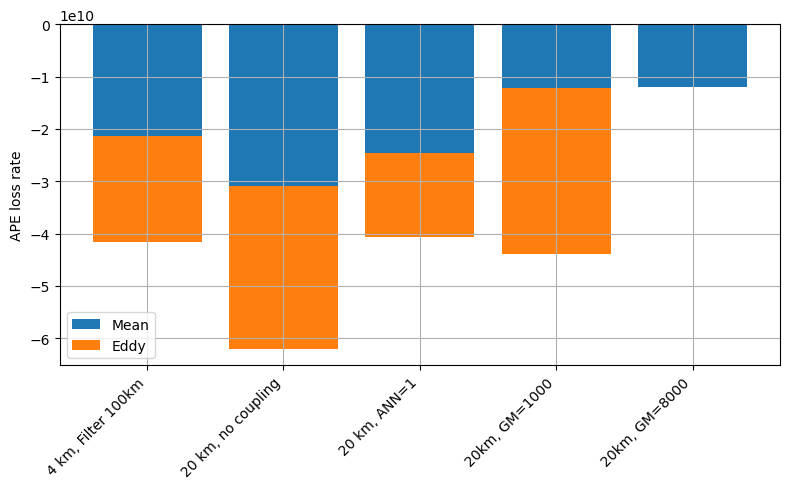

In [36]:
# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(exp_names_mod))

# Plot the resolved part (bottom)
ax.bar(x, ape_reduce_rate_mean, label='Mean')

# Plot the param part (stacked on top)
ax.bar(x, ape_reduce_rate_eddy, bottom=ape_reduce_rate_mean, label='Eddy')

# Labeling
ax.set_xticks(x)
ax.set_xticklabels(exp_names_mod, rotation=45, ha='right')
ax.set_ylabel('APE loss rate')
#ax.set_title('Stacked Vbar (Resolved + Param)')
ax.legend()

#ax.set_ylim(5e17, 7e17)
plt.grid()
plt.tight_layout()

plt.savefig('ape_reduce_rate.png')

## Mean forcing

In [37]:
exp_tree = exp_tree.map_over_subtree(sam.calc_SG_forcing)

### APE reduce rates over scales

In [38]:
def add_cross_spec(ds):
    if 'RV' in ds:
        ds = ds.copy()

        
        CS_x = xrft.cross_spectrum(ds.Fx, ds.dhdx, dim='xh', window=None, density=False)
        CS_y = xrft.cross_spectrum(ds.Fy, ds.dhdy, dim='xh', window=None, density=False)
    
        ds['cross_spec_APE_reduce_net'] = (CS_x + CS_y).isel(Time=slice(72, None), zl=1).mean(['Time','yh']).real

        CS2 = xrft.cross_spectrum(ds.SG_forc.isel(zl=1), ds.e.isel(zi=1) - 500, dim='xh', window=None, density=False)
        #CS2_y = xrft.cross_spectrum(ds.SG_forc.isel(zl=1), ds.e.isel(zi=1) - 500, dim='xh', window=None, density=False)

        ds['cross_spec_APE_reduce_full'] = CS2.isel(Time=slice(72, None)).mean(['Time','yh']).real

    
        CS_norm = xrft.power_spectrum(ds.e.isel(zi=1) - 500, dim='xh', window=None, density=False)

        ds['e_spec'] = CS_norm.isel(Time=slice(72, None)).mean(['Time','yh'])

        ds['cross_spec_APE_reduce_full_norm'] = ((CS2 ).isel(Time=slice(72, None)).mean(['Time','yh']).real)/ CS_norm.isel(Time=slice(72, None)).mean(['Time','yh'])
    
    else:
        pass

    return ds

In [39]:
exp_tree  = exp_tree.map_over_subtree(add_cross_spec)

/ext3/miniforge/lib/python3.10/site-packages/xrft/xrft.py:844: FutureWarning: density flag will be deprecated in future version of xrft.cross_spectrum and replaced by scaling flag. density=True should be replaced by scaling="density" and density=False will not be maintained.
scaling flag is ignored !
  warnings.warn(msg, FutureWarning)
/ext3/miniforge/lib/python3.10/site-packages/xrft/xrft.py:844: FutureWarning: density flag will be deprecated in future version of xrft.cross_spectrum and replaced by scaling flag. density=True should be replaced by scaling="density" and density=False will not be maintained.
scaling flag is ignored !
  warnings.warn(msg, FutureWarning)
/ext3/miniforge/lib/python3.10/site-packages/xrft/xrft.py:844: FutureWarning: density flag will be deprecated in future version of xrft.cross_spectrum and replaced by scaling flag. density=True should be replaced by scaling="density" and density=False will not be maintained.
scaling flag is ignored !
  warnings.warn(msg, F

In [40]:
exp_ds = [ds_HR, 
          exp_tree['ANN']['20']['0.0']['prog'],
          exp_tree['ANN']['20']['1.0']['prog'],
          exp_tree['GM1000']['20']['1.0']['prog'],
          exp_tree['GM1000']['20']['8.0']['prog']]

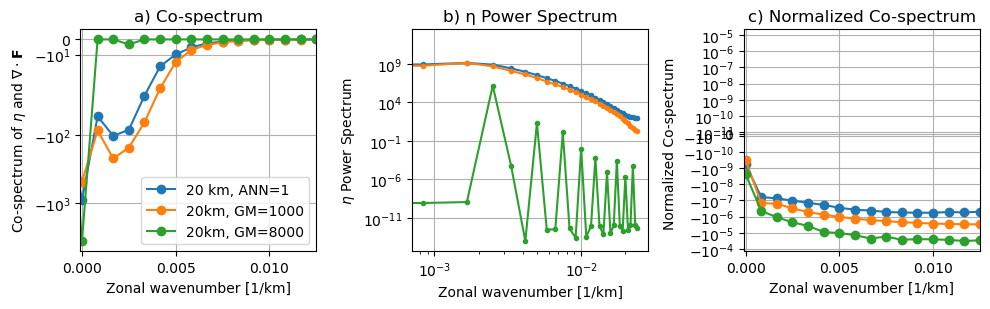

In [46]:
plt.figure(figsize=(10, 3.2))

# --- Subplot 1 ---
plt.subplot(131)
for i, ds in enumerate(exp_ds):
    if i > 1:
        ds.cross_spec_APE_reduce_full.plot(label=exp_names_mod[i], marker='o')

plt.yscale('symlog', linthresh=50)
plt.grid()
plt.xlim([-1/10000, 1/80])
plt.legend(loc='lower right')
plt.xlabel('Zonal wavenumber [1/km]')
plt.ylabel(r'Co-spectrum of $\eta$ and $\nabla \cdot \mathbf{F}$')
plt.title('a) Co-spectrum')

# --- Subplot 2 ---
plt.subplot(132)
for i, ds in enumerate(exp_ds):
    if i > 1:
        ds.e_spec.plot(label=exp_names_mod[i], marker='.')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Zonal wavenumber [1/km]')
plt.ylabel(r'$\eta$ Power Spectrum')
plt.title('b) η Power Spectrum')

# --- Subplot 3 ---
plt.subplot(133)
for i, ds in enumerate(exp_ds):
    if i > 1:
        (ds.cross_spec_APE_reduce_full_norm * ds.freq_xh).plot(label=exp_names_mod[i], marker='o')

plt.xscale('log')
plt.yscale('symlog', linthresh=1e-9)
plt.grid()
plt.xlabel('Zonal wavenumber [1/km]')
#plt.ylabel(r'Normalized Co-spectrum: $\eta \cdot \nabla \cdot \mathbf{F}$ × wavenumber')
plt.ylabel(r'Normalized Co-spectrum ')

plt.title('c) Normalized Co-spectrum')
#plt.legend(loc='lower right')

plt.tight_layout()

#plt.savefig('ape_reduce_rate_across_scale.png')

In [ ]:
plt.figure(figsize=(10, 3.2))

# --- Subplot 1 ---
plt.subplot(131)
for i, ds in enumerate(exp_ds):
    if i > 1:
        ds.cross_spec_APE_reduce_full.plot(label=exp_names_mod[i], marker='o')

plt.yscale('symlog', linthresh=50)
plt.grid()
plt.xlim([-1/10000, 1/80])
plt.legend(loc='lower right')
plt.xlabel('Zonal wavenumber [1/km]')
plt.ylabel(r'Co-spectrum of $\eta$ and $\nabla \cdot \mathbf{F}$')
plt.title('a) Co-spectrum')

# --- Subplot 2 ---
plt.subplot(132)
for i, ds in enumerate(exp_ds):
    if i > 1:
        ds.e_spec.plot(label=exp_names_mod[i], marker='.')

plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.xlabel('Zonal wavenumber [1/km]')
plt.ylabel(r'$\eta$ Power Spectrum')
plt.title('b) η Power Spectrum')

# --- Subplot 3 ---
plt.subplot(133)
for i, ds in enumerate(exp_ds):
    if i > 1:
        #(ds.cross_spec_APE_reduce_full_norm * ds.freq_xh).plot(label=exp_names_mod[i], marker='o')
        (ds.cross_spec_APE_reduce_full_norm ).plot(label=exp_names_mod[i], marker='o')

#plt.xscale('log')
plt.yscale('symlog', linthresh=1e-10)
plt.grid()
plt.xlabel('Zonal wavenumber [1/km]')
#plt.ylabel(r'Normalized Co-spectrum: $\eta \cdot \nabla \cdot \mathbf{F}$ × wavenumber')
plt.ylabel(r'Normalized Co-spectrum ')
plt.xlim([-1/10000, 1/80])

plt.title('c) Normalized Co-spectrum')
#plt.legend(loc='lower right')

plt.tight_layout()

#plt.savefig('ape_reduce_rate_across_scale.png')